The goal of this notebook is to construct linear state observers based on the models generated by each model reduction method

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
import mat73
from scipy import signal
import control
import dask.array as da
from dask.distributed import Client, LocalCluster


import opinf


config = dotenv_values(".env")
from util import *

In [2]:
# Setup Dask client
# cluster = LocalCluster() # Launches a scheduler and workers locally
# client = Client(cluster) # Connect to distributed cluster and override default
client = Client('tcp://127.0.0.1:8786')
client.cluster

In [3]:
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForICRA/"
# Read in system and gain matrices from .mat file
systemMats = scipy.io.loadmat(filepath + "romSystemMatricesAndGains_22dim_3train_2test.mat")
# ERA matrices
A_era = systemMats["A_era"]
B_era = systemMats["B_era"]
C_era = systemMats["C_era"]
D_era = systemMats["D_era"]
L_era = systemMats["L_era"]
# DMDc Matrices
A_dmdc = systemMats["A_dmdc"]
B_dmdc = systemMats["B_dmdc"]
C_dmdc = systemMats["C_dmdc"]
L_dmdc = systemMats["L_dmdc"]
# LOpInf Matrices
A_lopInf = systemMats["A_lopinf"]
B_lopInf = systemMats["B_lopinf"]
C_lopInf = systemMats["C_lopinf"]
D_lopInf = systemMats["D_lopinf"]
L_lopInf = systemMats["L_lopinf"]

# Read in offset vector
x0 = systemMats["x0"]

In [4]:
n_train = 3
n_test = 7

In [5]:
systemMats.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A_dmdc', 'A_era', 'A_lopinf', 'B_dmdc', 'B_era', 'B_lopinf', 'C_dmdc', 'C_era', 'C_lopinf', 'D_era', 'D_lopinf', 'L_dmdc', 'L_era', 'L_lopinf', 'basis_dmdc', 'basis_lopinf', 'poles', 'x0', 'y0'])

In [6]:
# Read in basis transformations for methods that enable state reconstruction
# lopinfOperators = scipy.io.loadmat(filepath + "lopinf_rom_r_6_operators.mat")
basis_dmdc = systemMats["basis_dmdc"]
basis_lopinf = systemMats["basis_lopinf"]
# Pad the lopinf basis with columns of 0s so that it has 12 columns
basis_lopinf = np.hstack((basis_lopinf, np.zeros((basis_lopinf.shape[0], basis_lopinf.shape[1]))))
# Convert to dask arrays
basis_dmdc = da.from_array(basis_dmdc, chunks=(4096, basis_dmdc.shape[1]))
basis_lopinf = da.from_array(basis_lopinf, chunks=(4096, basis_lopinf.shape[1]))



In [7]:
# Get dimension of output space of basis functions
basis_lopinf.shape[0]

231336

# Observer Comparison Experiments

In [8]:
# Load in data
data = h5py.File(filepath+ "fullDataSet.hdf5", 'r')
# Read in a trial
trial = 0
# Read in the data for the specific trial
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1)) # have to read in all training and test data
U_fom = data["inputData"][:,:,n_train:n_test+n_train] # only read in test data
Y_fom = data["reducedCenterlineData"][:,:,n_train:n_test+n_train] # only reads in test data
x0 = data["stateData"][:,0,0]
Y0 = data["reducedCenterlineData"][:,0,0]

# subtract initial condition from Y_fom for each trial
for i in range(Y_fom.shape[2]):
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y_fom[:,0,i].reshape(-1,1)

timesteps = Y_fom.shape[1]
# Save state data to so we can memmap it later
# np.save(filepath + "temp/stateData.npy", data["stateData"])
# Extract simulation parameters
numTrials = data["reducedCenterlineData"].shape[2]



In [11]:
# Generate open and closed loop responses for each observer for every trial
# Initialize arrays to store data
# ERA
x_hat_era = np.zeros((A_era.shape[0], timesteps, n_test)) # Closed loop era observer
x_hat_ol_era = np.zeros((A_era.shape[0], timesteps, n_test)) # Open loop era observer
y_hat_era = np.zeros((C_era.shape[0], timesteps, n_test)) # Closed loop era observer
y_hat_ol_era = np.zeros((C_era.shape[0], timesteps, n_test)) # Open loop era observer
# DMDc
x_hat_dmdc = np.zeros((A_dmdc.shape[0], timesteps, n_test)) # Closed loop dmdc observer
x_hat_ol_dmdc = np.zeros((A_dmdc.shape[0], timesteps, n_test)) # Open loop dmdc observer
y_hat_dmdc = np.zeros((C_dmdc.shape[0], timesteps, n_test)) # Closed loop dmdc observer
y_hat_ol_dmdc = np.zeros((C_dmdc.shape[0], timesteps, n_test)) # Open loop dmdc observer
# LOpinf
x_hat_lopInf = np.zeros((A_lopInf.shape[0], timesteps, n_test)) # Closed loop lopinf observer
x_hat_ol_lopInf = np.zeros((A_lopInf.shape[0], timesteps, n_test)) # Open loop lopinf observer  
y_hat_lopInf = np.zeros((C_lopInf.shape[0], timesteps, n_test)) # Closed loop lopinf observer
y_hat_ol_lopInf = np.zeros((C_lopInf.shape[0], timesteps, n_test)) # Open loop lopinf observer

# Iterate through each trial
for trial in range(n_test):
    # Iterate through each timestep applying observer update law
    for i in range(timesteps-1):
        # Update observer states
        x_hat_era[:,i+1,trial] = A_era @ x_hat_era[:,i,trial] +B_era@U_fom[:,i,trial] - L_era @ (y_hat_era[:,i,trial] - Y_fom[:,i,trial]) # Closed loop era observer
        x_hat_ol_era[:,i+1,trial] = A_era @ x_hat_ol_era[:,i,trial] +B_era@U_fom[:,i,trial] # Open loop era observer
        x_hat_dmdc[:,i+1,trial] = A_dmdc @ x_hat_dmdc[:,i,trial] +B_dmdc@U_fom[:,i,trial] - L_dmdc @ (y_hat_dmdc[:,i,trial] - Y_fom[:,i,trial]) # Closed loop dmdc observer
        x_hat_ol_dmdc[:,i+1,trial] = A_dmdc @ x_hat_ol_dmdc[:,i,trial] +B_dmdc@U_fom[:,i,trial] # Open loop dmdc observer
        x_hat_lopInf[:,i+1,trial] = A_lopInf @ x_hat_lopInf[:,i,trial] +B_lopInf@U_fom[:,i,trial] - L_lopInf @ (y_hat_lopInf[:,i,trial] - Y_fom[:,i,trial]) # Closed loop lopinf observer
        x_hat_ol_lopInf[:,i+1,trial] = A_lopInf @ x_hat_ol_lopInf[:,i,trial] +B_lopInf@U_fom[:,i,trial] # Open loop lopinf observer

        # Update observer output
        y_hat_era[:,i+1,trial] = C_era @ x_hat_era[:,i+1,trial] + D_era @ U_fom[:,i,trial] # Closed loop era observer
        y_hat_ol_era[:,i+1,trial] = C_era @ x_hat_ol_era[:,i+1,trial] + D_era @ U_fom[:,i,trial] # Open loop era observer
        y_hat_dmdc[:,i+1,trial] = C_dmdc @ x_hat_dmdc[:,i+1,trial] # Closed loop dmdc observer
        y_hat_ol_dmdc[:,i+1,trial] = C_dmdc @ x_hat_ol_dmdc[:,i+1,trial]  # Open loop dmdc observer
        y_hat_lopInf[:,i+1,trial] = C_lopInf @ x_hat_lopInf[:,i+1,trial] # Closed loop lopinf observer
        y_hat_ol_lopInf[:,i+1,trial] = C_lopInf @ x_hat_ol_lopInf[:,i+1,trial] # Open loop lopinf observer
        

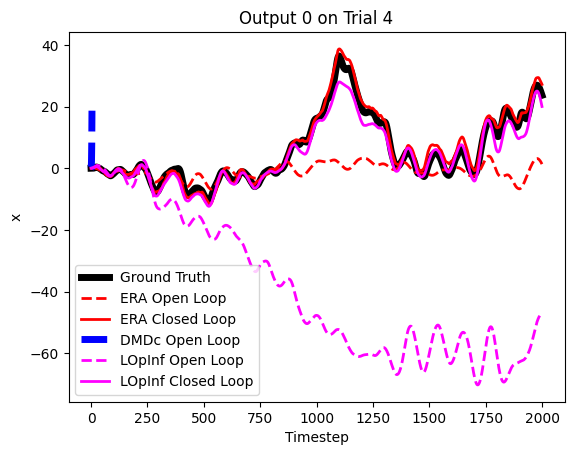

In [12]:
# Plot results for a specific trial with open loop responses in dashed lines and closed loop responses in solid lines and ground truth in black

trial = 4
fig, ax = plt.subplots()


# plt.figure()
ax.plot(Y_fom[0,:,trial], label="Ground Truth", color="black", linewidth=5)
ax.plot(y_hat_ol_era[0,:,trial], "--", label="ERA Open Loop", color="red", linewidth=2)
ax.plot(y_hat_era[0,:,trial], label="ERA Closed Loop", color="red", linewidth=2)
ax.plot(y_hat_ol_dmdc[0,0:5,trial], "--", label="DMDc Open Loop", color="blue", linewidth=5)
# ax.plot(y_hat_dmdc[0,0:5,trial], label="DMDc Closed Loop", color="blue", linewidth=5)
# plt.plot(y_hat_ol_opInf[0,:,trial], "--", label="OpInf Open Loop", color="green", linewidth=5)
# plt.plot(y_hat_opInf[0,:,trial], label="OpInf Closed Loop", color="green", linewidth=5)
ax.plot(y_hat_ol_lopInf[0,:,trial], "--", label="LOpInf Open Loop", color="magenta", linewidth=2)
ax.plot(y_hat_lopInf[0,:,trial], label="LOpInf Closed Loop", color="magenta", linewidth=2)
ax.set_xlabel("Timestep")
ax.set_ylabel("x")
ax.set_title("Output 0 on Trial " + str(trial))
ax.legend()
# Save as svg
# plt.savefig("output0_trial" + str(trial) + ".pdf", format="pdf")

In [13]:
# Convert everything to dask arrays
x0 = da.from_array(x0, chunks=4096)
Y_fom = da.from_array(Y_fom, chunks=4096)
U_fom = da.from_array(U_fom, chunks=4096)

# Convert all rom state arrays to dask arrays
x_hat_era = da.from_array(x_hat_era, chunks=(x_hat_era.shape[0], x_hat_era.shape[1], x_hat_era.shape[2]))
x_hat_ol_era = da.from_array(x_hat_ol_era, chunks=(x_hat_ol_era.shape[0], x_hat_ol_era.shape[1], x_hat_ol_era.shape[2]))
y_hat_era = da.from_array(y_hat_era, chunks=(y_hat_era.shape[0], y_hat_era.shape[1], y_hat_era.shape[2]))
y_hat_ol_era = da.from_array(y_hat_ol_era, chunks=(y_hat_ol_era.shape[0], y_hat_ol_era.shape[1], y_hat_ol_era.shape[2]))
x_hat_dmdc = da.from_array(x_hat_dmdc, chunks=(x_hat_dmdc.shape[0], x_hat_dmdc.shape[1], x_hat_dmdc.shape[2]))
x_hat_ol_dmdc = da.from_array(x_hat_ol_dmdc, chunks=(x_hat_ol_dmdc.shape[0], x_hat_ol_dmdc.shape[1], x_hat_ol_dmdc.shape[2]))
y_hat_dmdc = da.from_array(y_hat_dmdc, chunks=(y_hat_dmdc.shape[0], y_hat_dmdc.shape[1], y_hat_dmdc.shape[2]))
y_hat_ol_dmdc = da.from_array(y_hat_ol_dmdc, chunks=(y_hat_ol_dmdc.shape[0], y_hat_ol_dmdc.shape[1], y_hat_ol_dmdc.shape[2]))
x_hat_lopInf = da.from_array(x_hat_lopInf, chunks=(x_hat_lopInf.shape[0], x_hat_lopInf.shape[1], x_hat_lopInf.shape[2]))
x_hat_ol_lopInf = da.from_array(x_hat_ol_lopInf, chunks=(x_hat_ol_lopInf.shape[0], x_hat_ol_lopInf.shape[1], x_hat_ol_lopInf.shape[2]))
y_hat_lopInf = da.from_array(y_hat_lopInf, chunks=(y_hat_lopInf.shape[0], y_hat_lopInf.shape[1], y_hat_lopInf.shape[2]))
y_hat_ol_lopInf = da.from_array(y_hat_ol_lopInf, chunks=(y_hat_ol_lopInf.shape[0], y_hat_ol_lopInf.shape[1], y_hat_ol_lopInf.shape[2]))



In [14]:
# Compute open and closed loop RRMS output errors for each method in each trial
# Initialize arrays to store open loop and closed loop RMS errors
rms_era = da.zeros((2, n_test)) # ERA
rms_dmdc = da.zeros((2, n_test)) # DMDc
rms_lopInf = da.zeros((2, n_test)) # LOpInf
# Iterate through each trial
for trial in range(n_test):
    # Compute open loop RMS error
    rms_era[0,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_ol_era[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))
    rms_dmdc[0,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_ol_dmdc[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))
    rms_lopInf[0,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_ol_lopInf[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))
    # Compute closed loop RMS error
    rms_era[1,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_era[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))
    rms_dmdc[1,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_dmdc[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))
    rms_lopInf[1,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_lopInf[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))


In [15]:
# Execute dask arrays
rms_era, rms_dmdc, rms_lopInf = da.compute(rms_era, rms_dmdc, rms_lopInf)


In [16]:
# Make table of mean +/- standard deviation, max, and min of RMS errors for each method
# Initialize table
rms_table = PrettyTable()
rms_table.field_names = ["Method", "Mean +/- Std Dev", "Max", "Min"]
# Add rows to table
rms_table.add_row(["ERA Open Loop", str(np.mean(rms_era[0,:])) + " +/- " + str(np.std(rms_era[0,:])), str(np.max(rms_era[0,:])) + " in trial " + str(np.argmax(rms_era[0,:])), str(np.min(rms_era[0,:])) + " in trial " + str(np.argmin(rms_era[0,:]))])
rms_table.add_row(["ERA Closed Loop", str(np.mean(rms_era[1,:])) + " +/- " + str(np.std(rms_era[1,:])), str(np.max(rms_era[1,:])) + " in trial " + str(np.argmax(rms_era[1,:])), str(np.min(rms_era[1,:])) + " in trial " + str(np.argmin(rms_era[1,:]))])
rms_table.add_row(["DMDc Open Loop", str(np.mean(rms_dmdc[0,:])) + " +/- " + str(np.std(rms_dmdc[0,:])), str(np.max(rms_dmdc[0,:])) + " in trial " + str(np.argmax(rms_dmdc[0,:])), str(np.min(rms_dmdc[0,:])) + " in trial " + str(np.argmin(rms_dmdc[0,:]))])
rms_table.add_row(["DMDc Closed Loop", str(np.mean(rms_dmdc[1,:])) + " +/- " + str(np.std(rms_dmdc[1,:])), str(np.max(rms_dmdc[1,:])) + " in trial " + str(np.argmax(rms_dmdc[1,:])), str(np.min(rms_dmdc[1,:])) + " in trial " + str(np.argmin(rms_dmdc[1,:]))])
rms_table.add_row(["LOpInf Open Loop", str(np.mean(rms_lopInf[0,:])) + " +/- " + str(np.std(rms_lopInf[0,:])), str(np.max(rms_lopInf[0,:])) + " in trial " + str(np.argmax(rms_lopInf[0,:])), str(np.min(rms_lopInf[0,:])) + " in trial " + str(np.argmin(rms_lopInf[0,:]))])
rms_table.add_row(["LOpInf Closed Loop", str(np.mean(rms_lopInf[1,:])) + " +/- " + str(np.std(rms_lopInf[1,:])), str(np.max(rms_lopInf[1,:])) + " in trial " + str(np.argmax(rms_lopInf[1,:])), str(np.min(rms_lopInf[1,:])) + " in trial " + str(np.argmin(rms_lopInf[1,:]))])
# Print table
print(rms_table)



+--------------------+--------------------------------------------------+----------------------------------+----------------------------------+
|       Method       |                 Mean +/- Std Dev                 |               Max                |               Min                |
+--------------------+--------------------------------------------------+----------------------------------+----------------------------------+
|   ERA Open Loop    |   0.24004912743797766 +/- 0.05693297679528482    |  0.3002838249790466 in trial 5   |  0.13154491195087017 in trial 6  |
|  ERA Closed Loop   |  0.014120983038910349 +/- 0.0031921533301265013  |  0.01945727831914138 in trial 5  | 0.009536984709419032 in trial 3  |
|   DMDc Open Loop   | 2.9521573298845275e+23 +/- 1.719082734655337e+23 | 5.734210593437479e+23 in trial 1 | 7.846679294919051e+22 in trial 6 |
|  DMDc Closed Loop  |    24.000697447652847 +/- 3.5616453304796556     |  28.920209825582862 in trial 1   |  18.026619478872426 in tria

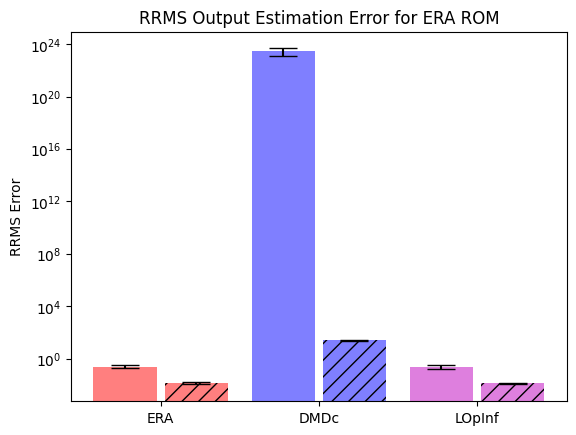

In [17]:
# Bar plot with error bars of open loop and closed loop RMS output errors for each method where open loop and closed loop responses are adjacent
fig, ax = plt.subplots()

ax.bar(np.arange(0,6,2)-0.45, [np.mean(rms_era[0,:]), np.mean(rms_dmdc[0,:]), np.mean(rms_lopInf[0,:])], yerr=[np.std(rms_era[0,:]), np.std(rms_dmdc[0,:]), np.std(rms_lopInf[0,:])], color=['r','b','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,6,2)+0.45, [np.mean(rms_era[1,:]), np.mean(rms_dmdc[1,:]), np.mean(rms_lopInf[1,:])], yerr=[np.std(rms_era[1,:]), np.std(rms_dmdc[1,:]), np.std(rms_lopInf[1,:])], color=['r','b','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')
# # Plot max and min of each method overlayed on bars
# ax.plot(np.arange(0,6,2)-0.45, [np.max(rms_era[0,:]), np.max(rms_dmdc[0,:]), np.max(rms_lopInf[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,6,2)-0.45, [np.min(rms_era[0,:]), np.min(rms_dmdc[0,:]), np.min(rms_lopInf[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,6,2)+0.45, [np.max(rms_era[1,:]), np.max(rms_dmdc[1,:]), np.max(rms_lopInf[1,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,6,2)+0.45, [np.min(rms_era[1,:]), np.min(rms_dmdc[1,:]), np.min(rms_lopInf[1,:])], 'k_', markersize=10, markeredgewidth=3)



ax.set_xticks(np.arange(0,6,2))
ax.set_xticklabels(['ERA','DMDc','LOpInf'])
ax.set_yticks([0,1,2])


ax.set_ylabel("RRMS Error")
ax.set_title("RRMS Output Estimation Error for ERA ROM")
# TODO: Fix legend

# Set legend where solid box is open loop and hatched box is closed loop
# ax.legend(['Max','Min','Open Loop','Closed Loop'],loc='upper left')
# Change to log scale y axis
ax.set_yscale('log')


# Save as svg
plt.savefig('RMSOutputEstimation.pdf', format='pdf', dpi=1200)

In [18]:
# Reconstruct full order states for DMDc and LOpInf using the basis transformations for every trial in the open and closed loop cases
# Initialize arrays to store reconstructed states
# DMDc
x_hat_dmdc_full = da.zeros((basis_dmdc.shape[0], timesteps, n_test), chunks=(10000, timesteps, 1))
x_hat_ol_dmdc_full = da.zeros((basis_dmdc.shape[0], timesteps, n_test), chunks=(10000, timesteps, 1))
# LOpinf
x_hat_lopInf_full = da.zeros((basis_lopinf.shape[0], timesteps, n_test), chunks=(10000, timesteps, 1))
x_hat_ol_lopInf_full = da.zeros((basis_lopinf.shape[0], timesteps, n_test), chunks=(10000, timesteps, 1))

# For each timestep of each trial, reconstruct the full order state using the basis transformation
for trial in range(n_test):
    x_hat_dmdc_full[:,:,trial] = basis_dmdc @ x_hat_dmdc[:,:,trial]
    x_hat_ol_dmdc_full[:,:,trial] = basis_dmdc @ x_hat_ol_dmdc[:,:,trial]
    x_hat_lopInf_full[:,:,trial] = basis_lopinf @ x_hat_lopInf[:,:,trial]
    x_hat_ol_lopInf_full[:,:,trial] = basis_lopinf @ x_hat_ol_lopInf[:,:,trial]

In [20]:
# Read in full state data from  as dask array
stateData = da.from_array(data['stateData'], chunks=(10000, timesteps, 1))
stateData = stateData[:,:,n_train:n_test+n_train] # only read in test data
# Center state data for each trial
for trial in range(n_test):
    stateData[:,:,trial] = stateData[:,:,trial] - stateData[:,0,trial].reshape(-1,1)

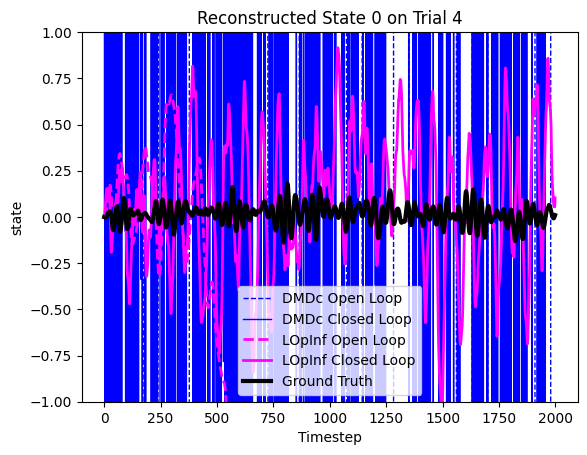

In [21]:
# Plot results for a specific trial with open loop responses in dashed lines and closed loop responses in solid lines and ground truth in black
trial = 4
stateIdx = 0
plt.figure()
plt.plot(x_hat_ol_dmdc_full[stateIdx,:,trial].compute(), "--", label="DMDc Open Loop", color="blue", linewidth=1)
plt.plot(x_hat_dmdc_full[stateIdx,:,trial].compute(), label="DMDc Closed Loop", color="blue", linewidth=1)
plt.plot(x_hat_ol_lopInf_full[stateIdx,:,trial].compute(), "--", label="LOpInf Open Loop", color="magenta", linewidth=2)
plt.plot(x_hat_lopInf_full[stateIdx,:,trial].compute(), label="LOpInf Closed Loop", color="magenta", linewidth=2)
plt.plot(stateData[stateIdx,:,trial].compute(), label="Ground Truth", color="black", linewidth=3)

plt.xlabel("Timestep")
plt.ylabel("state")
plt.ylim([-1, 1])
plt.title("Reconstructed State 0 on Trial " + str(trial))
plt.legend()
# plt.show()



In [23]:
# Compute open and closed loop RRMS state errors for each method in each trial
# Initialize arrays to store open loop and closed loop RMS errors
rms_dmdc_full = da.zeros((2, n_test)) # DMDc
rms_lopInf_full = da.zeros((2, n_test)) # LOpInf
# Iterate through each trial
for trial in range(n_test):
    # Compute open loop RMS error
    rms_dmdc_full[0,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_ol_dmdc_full[:,:,trial]))/da.linalg.norm(stateData[:,:,trial], ord='fro'))
    rms_lopInf_full[0,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_ol_lopInf_full[:,:,trial]))/da.linalg.norm(stateData[:,:,trial], ord='fro'))
    # Compute closed loop RMS error
    rms_dmdc_full[1,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_dmdc_full[:,:,trial]))/da.linalg.norm(stateData[:,:,trial], ord='fro'))
    rms_lopInf_full[1,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_lopInf_full[:,:,trial]))/da.linalg.norm(stateData[:,:,trial], ord='fro'))


In [24]:
# Execute dask arrays 
rms_dmdc_full, rms_lopInf_full = da.compute(rms_dmdc_full, rms_lopInf_full)


In [25]:
# Make table of mean +/- standard deviation, max, and min of RMS errors for each method
# Initialize table
rms_table = PrettyTable()
rms_table.field_names = ["Method", "Mean +/- Std Dev", "Max", "Min"]
# Add rows to table
rms_table.add_row(["DMDc Open Loop", str(np.mean(rms_dmdc_full[0,:])) + " +/- " + str(np.std(rms_dmdc_full[0,:])), str(np.max(rms_dmdc_full[0,:])) + " in trial " + str(np.argmax(rms_dmdc_full[0,:])), str(np.min(rms_dmdc_full[0,:])) + " in trial " + str(np.argmin(rms_dmdc_full[0,:]))])
rms_table.add_row(["DMDc Closed Loop", str(np.mean(rms_dmdc_full[1,:])) + " +/- " + str(np.std(rms_dmdc_full[1,:])), str(np.max(rms_dmdc_full[1,:])) + " in trial " + str(np.argmax(rms_dmdc_full[1,:])), str(np.min(rms_dmdc_full[1,:])) + " in trial " + str(np.argmin(rms_dmdc_full[1,:]))])
rms_table.add_row(["LOpInf Open Loop", str(np.mean(rms_lopInf_full[0,:])) + " +/- " + str(np.std(rms_lopInf_full[0,:])), str(np.max(rms_lopInf_full[0,:])) + " in trial " + str(np.argmax(rms_lopInf_full[0,:])), str(np.min(rms_lopInf_full[0,:])) + " in trial " + str(np.argmin(rms_lopInf_full[0,:]))])
rms_table.add_row(["LOpInf Closed Loop", str(np.mean(rms_lopInf_full[1,:])) + " +/- " + str(np.std(rms_lopInf_full[1,:])), str(np.max(rms_lopInf_full[1,:])) + " in trial " + str(np.argmax(rms_lopInf_full[1,:])), str(np.min(rms_lopInf_full[1,:])) + " in trial " + str(np.argmin(rms_lopInf_full[1,:]))])
# Print table
print(rms_table)

+--------------------+---------------------------------------------------+----------------------------------+-----------------------------------+
|       Method       |                  Mean +/- Std Dev                 |               Max                |                Min                |
+--------------------+---------------------------------------------------+----------------------------------+-----------------------------------+
|   DMDc Open Loop   | 2.1308416795756044e+19 +/- 1.4921639808639877e+19 | 4.944411989338194e+19 in trial 4 | 4.2959605799692974e+18 in trial 6 |
|  DMDc Closed Loop  |     5.5806543618783575 +/- 0.4299310580202947     |   6.116511589721558 in trial 5   |    4.651457754520501 in trial 2   |
|  LOpInf Open Loop  |    0.02393431280835266 +/- 0.008686046334562597   | 0.040873938842232074 in trial 5  |  0.011542331508857749 in trial 3  |
| LOpInf Closed Loop |   0.005275127001284133 +/- 0.0005716982213208846  | 0.006043670997956407 in trial 6  |   0.0043000512

Text(0.5, 1.0, 'RRMS State Estimation Error for DMDc ROM')

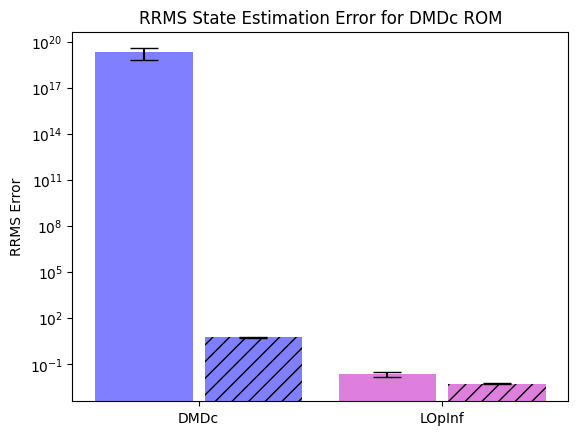

In [26]:
# Bar plot with error bars of open loop and closed loop RMS state errors for each method where open loop and closed loop responses are adjacent
fig, ax = plt.subplots()

# ax.figure(figsize=(10,5))
ax.bar(np.arange(0,4,2)-0.45, [np.mean(rms_dmdc_full[0,:]), np.mean(rms_lopInf_full[0,:])], yerr=[np.std(rms_dmdc_full[0,:]), np.std(rms_lopInf_full[0,:])], color=['b','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,4,2)+0.45, [np.mean(rms_dmdc_full[1,:]), np.mean(rms_lopInf_full[1,:])], yerr=[np.std(rms_dmdc_full[1,:]), np.std(rms_lopInf_full[1,:])], color=['b','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')

# Plot max and min of each method overlayed on bars
# ax.plot(np.arange(0,4,2)-0.45, [np.max(rms_dmdc_full[0,:]), np.max(rms_lopInf_full[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,4,2)-0.45, [np.min(rms_dmdc_full[0,:]), np.min(rms_lopInf_full[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,4,2)+0.45, [np.max(rms_dmdc_full[1,:]), np.max(rms_lopInf_full[1,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,4,2)+0.45, [np.min(rms_dmdc_full[1,:]), np.min(rms_lopInf_full[1,:])], 'k_', markersize=10, markeredgewidth=3)

# Change to log scale y axis
ax.set_yscale('log')

ax.set_xticks(np.arange(0,4,2))
ax.set_xticklabels(['DMDc','LOpInf'])
# ax.set_yticks([1e0,1e1,1e2])



ax.set_ylabel("RRMS Error")
ax.set_title("RRMS State Estimation Error for DMDc ROM")
# Make legend where hatched boxes correspond to closed loop responses and solid boxes correspond to open loop responses

# Save as svg
# plt.savefig('stateObserverAnalysis.pdf', format='pdf', dpi=1200)


# Prediction Horizon Experiments

In [27]:
# Compute output RRMSE for each method as a function of prediction horizon

# Read in the data set
U_fom = data["inputData"][:,:,n_train:n_test+n_train]
Y_fom = data["reducedCenterlineData"][:,:,n_train:n_test+n_train]
# subtract initial condition from Y_fom for each trial
for i in range(Y_fom.shape[2]):
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y_fom[:,0,i].reshape(-1,1)

# Initialize arrays to store state etimates and outputs for each method
# ERA
x_hat_era = np.zeros((A_era.shape[0], timesteps, n_test)) # Closed loop era observer
y_hat_era = np.zeros((C_era.shape[0], timesteps, n_test)) # Closed loop era observer
# DMDc
x_hat_dmdc = np.zeros((A_dmdc.shape[0], timesteps, n_test)) # Closed loop dmdc observer
y_hat_dmdc = np.zeros((C_dmdc.shape[0], timesteps, n_test)) # Closed loop dmdc observer
# LOpinf
x_hat_lopInf = np.zeros((A_lopInf.shape[0], timesteps, n_test)) # Closed loop lopinf observer
y_hat_lopInf = np.zeros((C_lopInf.shape[0], timesteps, n_test)) # Closed loop lopinf observer

# Iterate through each trial
for trial in range(n_test):
    # Iterate through each timestep applying observer update law
    for i in range(timesteps-1):
        # Update observer states
        x_hat_era[:,i+1,trial] = A_era @ x_hat_era[:,i,trial] +B_era@U_fom[:,i,trial] # Open loop era observer
        x_hat_dmdc[:,i+1,trial] = A_dmdc @ x_hat_dmdc[:,i,trial] +B_dmdc@U_fom[:,i,trial] # Open loop dmdc observer
        x_hat_lopInf[:,i+1,trial] = A_lopInf @ x_hat_lopInf[:,i,trial] +B_lopInf@U_fom[:,i,trial] # Open loop lopinf observer

        # Update observer output
        y_hat_era[:,i+1,trial] = C_era @ x_hat_era[:,i+1,trial] + D_era @ U_fom[:,i,trial] # Closed loop era observer
        y_hat_dmdc[:,i+1,trial] = C_dmdc @ x_hat_dmdc[:,i+1,trial] # Closed loop dmdc observer
        y_hat_lopInf[:,i+1,trial] = C_lopInf @ x_hat_lopInf[:,i+1,trial] # Closed loop lopinf observer
        
### Compute RRMSE and standard deviation of RRMSE for each method ### 
# Initialize arrays to store open loop and closed loop RMS errors
rms_era = np.zeros((n_test)) # ERA
rms_dmdc = np.zeros((n_test)) # DMDc
rms_lopInf = np.zeros((n_test)) # LOpInf
# Compute error vectors
error_era_mag = np.linalg.norm((Y_fom - y_hat_era),ord=2,axis=0)
error_dmdc_mag = np.linalg.norm((Y_fom - y_hat_dmdc),ord=2,axis=0)
error_lopInf_mag = np.linalg.norm((Y_fom - y_hat_lopInf),ord=2,axis=0)
# Compute magnitude of deflection
Y_fom_mag = np.linalg.norm(Y_fom,ord=2,axis=0)

# relative errors
rel_error_era = error_era_mag/Y_fom_mag
rel_error_dmdc = error_dmdc_mag/Y_fom_mag
rel_error_lopInf = error_lopInf_mag/Y_fom_mag

# average relative errors
rel_error_era_avg = np.mean(rel_error_era,axis=1)
rel_error_dmdc_avg = np.mean(rel_error_dmdc,axis=1)
rel_error_lopInf_avg = np.mean(rel_error_lopInf,axis=1)
# standard deviation of relative errors
rel_error_era_std = np.std(rel_error_era,axis=1)
rel_error_dmdc_std = np.std(rel_error_dmdc,axis=1)
rel_error_lopInf_std = np.std(rel_error_lopInf,axis=1)

# Average deflection magnitude
Y_fom_mag_avg = np.mean(Y_fom_mag,axis=1)
# standard deviation of deflection magnitude
Y_fom_mag_std = np.std(Y_fom_mag,axis=1)

# maximum deflection magnitude
Y_fom_mag_max = np.max(Y_fom_mag,axis=1)
# minimum deflection magnitude
Y_fom_mag_min = np.min(Y_fom_mag,axis=1)


Text(0, 0.5, 'Deflection Magnitude')

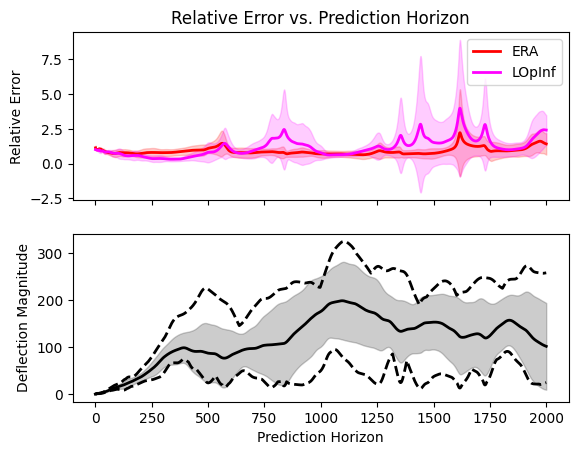

In [28]:
# Make figure with 2 vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# In the top subplot plot average relative errors and standard deviation of relative errors for each method as a function of prediction horizon with standard deviations as colored regions
ax1.plot(np.arange(0,timesteps), rel_error_era_avg, label="ERA", color="red", linewidth=2)
ax1.fill_between(np.arange(0,timesteps), rel_error_era_avg - rel_error_era_std, rel_error_era_avg + rel_error_era_std, color="red", alpha=0.2)
# ax1.plot(np.arange(0,timesteps), rel_error_dmdc_avg, label="DMDc", color="blue", linewidth=2)
# ax1.fill_between(np.arange(0,timesteps), rel_error_dmdc_avg - rel_error_dmdc_std, rel_error_dmdc_avg + rel_error_dmdc_std, color="blue", alpha=0.2)
ax1.plot(np.arange(0,timesteps), rel_error_lopInf_avg, label="LOpInf", color="magenta", linewidth=2)
ax1.fill_between(np.arange(0,timesteps), rel_error_lopInf_avg - rel_error_lopInf_std, rel_error_lopInf_avg + rel_error_lopInf_std, color="magenta", alpha=0.2)
# ax1.set_xlabel("Prediction Horizon")
ax1.set_ylabel("Relative Error")
ax1.set_title("Relative Error vs. Prediction Horizon")
# ax1.set_ylim([-2.5, 10])
ax1.legend()

# Bottom plot - average deflection magnitude and standard deviation of deflection magnitude for each method as a function of prediction horizon with standard deviations as colored regions
ax2.plot(np.arange(0,timesteps), Y_fom_mag_avg, label="Ground Truth", color="black", linewidth=2)
ax2.fill_between(np.arange(0,timesteps), Y_fom_mag_avg - Y_fom_mag_std, Y_fom_mag_avg + Y_fom_mag_std, color="black", alpha=0.2)
ax2.plot(np.arange(0,timesteps), Y_fom_mag_max, label="Ground Truth Max", color="black", linewidth=2, linestyle="--")
ax2.plot(np.arange(0,timesteps), Y_fom_mag_min, label="Ground Truth Min", color="black", linewidth=2, linestyle="--")
ax2.set_xlabel("Prediction Horizon")
ax2.set_ylabel("Deflection Magnitude")

# # Save as svg
# plt.savefig("relativeErrorVsHorizon.pdf", format="pdf", dpi=1200)


The deflection magnitude above represents the cumulative relative deflection of all of the points on the centerline. What is interesting is that both ERA and LOpInf have low error at points of high deflection but there are spikes in error when the deflection is somewhat lower. My initial thought as to why this is is because these spikes might be happening at points of high strain (and therefore high geometric nonlinearity) even though that strain might not be inducing a large cummulative displacement. 

One question you might have is "how could a high strain not introduce a large cummulative deflection?" My intuition-driven argument for how this might be possible is that a low-strain, gradual curve across the entire body of the robot could get the back of the robot to have a very high deflection, while another configuration where only the back end of the robot is severely flexed would not have a high cumulative deflection but would have a point of high strain (and therefore large contribution of geometric nonlinearity to the dynamics).

One way to test this might be to rerun the dataset but also collect the strains associated with each element in the mesh. However, this is time/compute intensive. A proxy experiment could be just looking at the reduced centerlines for each trial and computing the strain between neighboring points - essentially doing a discrete derivative over the centerline.


# Output noise sensitivity study

The goal of this portion is to determine how sensitive each observer is to noise in the output readings.

In [29]:
# Compute output RRMSE for each method as a function of sensor noise

# initialize arrays to store RRMSE for each method
numPoints = 50 # number of points to compute RRMSE for

# average relative errors
rel_error_era_avg = np.zeros((numPoints))
rel_error_dmdc_avg = np.zeros((numPoints))
rel_error_lopInf_avg = np.zeros((numPoints))
# standard deviation of relative errors
rel_error_era_std = np.zeros((numPoints))
rel_error_dmdc_std = np.zeros((numPoints))
rel_error_lopInf_std = np.zeros((numPoints))


# Gaussian noise parameters
min_noise = 0 # minimum standard deviation of noise
max_noise = 15 # maximum standard deviation of noise
mu_noise = 0 # mean of noise
sigmas_noise = np.linspace(min_noise,max_noise,numPoints) # standard deviation vector of noise



# Read in the data set
U_fom = data["inputData"][:,:,n_train:n_test+n_train]
Y_fom = data["reducedCenterlineData"][:,:,n_train:n_test+n_train]
# subtract initial condition from Y_fom for each trial
for i in range(Y_fom.shape[2]):
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y_fom[:,0,i].reshape(-1,1)

for idx, sigma_noise in enumerate(sigmas_noise):

    # Generate output noise snapshot matrix
    noise = np.random.normal(mu_noise, sigma_noise, (Y_fom.shape[0], Y_fom.shape[1], Y_fom.shape[2])) # noise snapshot matrix 


    # Initialize arrays to store state etimates and outputs for each method
    # ERA
    x_hat_era = np.zeros((A_era.shape[0], timesteps, n_test)) # Closed loop era observer
    y_hat_era = np.zeros((C_era.shape[0], timesteps, n_test)) # Closed loop era observer
    # DMDc
    x_hat_dmdc = np.zeros((A_dmdc.shape[0], timesteps, n_test)) # Closed loop dmdc observer
    y_hat_dmdc = np.zeros((C_dmdc.shape[0], timesteps, n_test)) # Closed loop dmdc observer
    # LOpinf
    x_hat_lopInf = np.zeros((A_lopInf.shape[0], timesteps, n_test)) # Closed loop lopinf observer
    y_hat_lopInf = np.zeros((C_lopInf.shape[0], timesteps, n_test)) # Closed loop lopinf observer

    # Iterate through each trial
    for trial in range(n_test):
        # Generate output noise snapshot matrix
        # Iterate through each timestep applying closed loop observer update law
        for i in range(timesteps-1):
            # Update observer states
            x_hat_era[:,i+1,trial] = A_era @ x_hat_era[:,i,trial] +B_era@U_fom[:,i,trial] - L_era @ (y_hat_era[:,i,trial] - (Y_fom[:,i,trial]+noise[:,i,trial])) # Closed loop era observer
            x_hat_dmdc[:,i+1,trial] = A_dmdc @ x_hat_dmdc[:,i,trial] +B_dmdc@U_fom[:,i,trial] - L_dmdc @ (y_hat_dmdc[:,i,trial] - (Y_fom[:,i,trial]+noise[:,i,trial])) # Closed loop dmdc observer
            x_hat_lopInf[:,i+1,trial] = A_lopInf @ x_hat_lopInf[:,i,trial] +B_lopInf@U_fom[:,i,trial] - L_lopInf @ (y_hat_lopInf[:,i,trial] - (Y_fom[:,i,trial]+noise[:,i,trial])) # Closed loop lopinf observer

            # Update observer output
            y_hat_era[:,i+1,trial] = C_era @ x_hat_era[:,i+1,trial] + D_era @ U_fom[:,i,trial] # Closed loop era observer
            y_hat_dmdc[:,i+1,trial] = C_dmdc @ x_hat_dmdc[:,i+1,trial] # Closed loop dmdc observer
            y_hat_lopInf[:,i+1,trial] = C_lopInf @ x_hat_lopInf[:,i+1,trial] # Closed loop lopinf observer
            
    ### Compute RRMSE and standard deviation of RRMSE for each method ### 
    # Initialize arrays to store open loop and closed loop RMS errors
    rms_era = np.zeros((n_test)) # ERA
    rms_dmdc = np.zeros((n_test)) # DMDc
    rms_lopInf = np.zeros((n_test)) # LOpInf
    # Compute error vectors
    error_era_mag = np.linalg.norm((Y_fom - y_hat_era),ord='fro',axis=(0,1))
    error_dmdc_mag = np.linalg.norm((Y_fom - y_hat_dmdc),ord='fro',axis=(0,1))
    error_lopInf_mag = np.linalg.norm((Y_fom - y_hat_lopInf),ord='fro',axis=(0,1))
    # Compute magnitude of deflection
    Y_fom_mag = np.linalg.norm(Y_fom,ord='fro',axis=(0,1))

    # relative errors
    rel_error_era = error_era_mag/Y_fom_mag
    rel_error_dmdc = error_dmdc_mag/Y_fom_mag
    rel_error_lopInf = error_lopInf_mag/Y_fom_mag

    # average relative errors
    rel_error_era_avg[idx] = np.mean(rel_error_era)
    rel_error_dmdc_avg[idx] = np.mean(rel_error_dmdc)
    rel_error_lopInf_avg[idx] = np.mean(rel_error_lopInf)
    # standard deviation of relative errors
    rel_error_era_std[idx] = np.std(rel_error_era)
    rel_error_dmdc_std[idx] = np.std(rel_error_dmdc)
    rel_error_lopInf_std[idx] = np.std(rel_error_lopInf)

# # Print results
# print("ERA: " + str(rel_error_era_avg) + " +/- " + str(rel_error_era_std))
# print("DMDc: " + str(rel_error_dmdc_avg) + " +/- " + str(rel_error_dmdc_std))
# print("LOpInf: " + str(rel_error_lopInf_avg) + " +/- " + str(rel_error_lopInf_std))

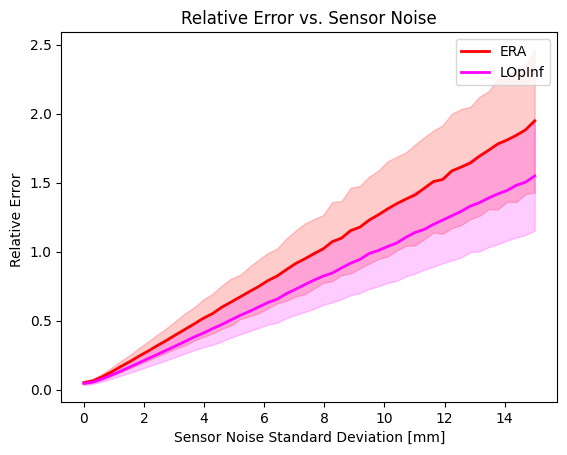

In [30]:
# Plot average relative error and standard deviation of relative error for each method as a function of sensor noise with standard deviations as colored regions
plt.figure()
plt.plot(sigmas_noise, rel_error_era_avg, label="ERA", color="red", linewidth=2)
plt.fill_between(sigmas_noise, rel_error_era_avg - rel_error_era_std, rel_error_era_avg + rel_error_era_std, color="red", alpha=0.2)
# plt.plot(sigmas_noise, rel_error_dmdc_avg, label="DMDc", color="blue", linewidth=2)
# plt.fill_between(sigmas_noise, rel_error_dmdc_avg - rel_error_dmdc_std, rel_error_dmdc_avg + rel_error_dmdc_std, color="blue", alpha=0.2)
plt.plot(sigmas_noise, rel_error_lopInf_avg, label="LOpInf", color="magenta", linewidth=2)
plt.fill_between(sigmas_noise, rel_error_lopInf_avg - rel_error_lopInf_std, rel_error_lopInf_avg + rel_error_lopInf_std, color="magenta", alpha=0.2)
plt.xlabel("Sensor Noise Standard Deviation [mm]")
plt.ylabel("Relative Error ")
plt.title("Relative Error vs. Sensor Noise")
plt.legend()
# plt.show()

# # Save as svg
# plt.savefig("relativeErrorVsNoise.pdf", format="pdf", dpi=1200)




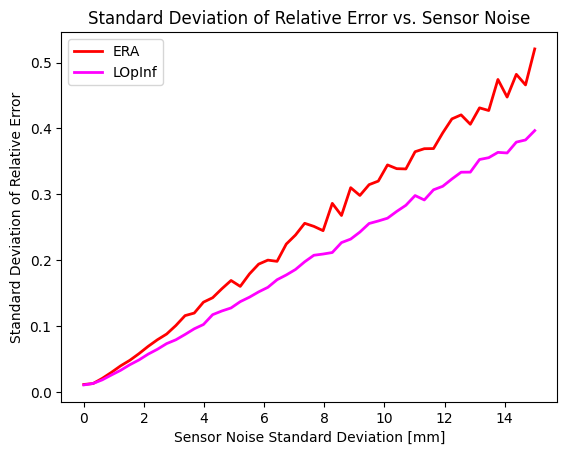

In [31]:
# plot variances of each method as a function of noise
plt.figure()
plt.plot(sigmas_noise, rel_error_era_std, label="ERA", color="red", linewidth=2)
# plt.plot(sigmas_noise, rel_error_dmdc_std, label="DMDc", color="blue", linewidth=2)
plt.plot(sigmas_noise, rel_error_lopInf_std, label="LOpInf", color="magenta", linewidth=2)
plt.xlabel("Sensor Noise Standard Deviation [mm]")
plt.ylabel("Standard Deviation of Relative Error")
plt.title("Standard Deviation of Relative Error vs. Sensor Noise")
plt.legend()
# plt.show()


It looks like for the most part, both the average relative error and standard deviation of the relative error scale linearly with the sensor noise. This is how a linear system would behave, which makes me think that for the most part, the simulation from which the dataset was collected exhibits mostly linear behavior.